Monte Carlo Simulations: 100%|██████████| 100/100 [04:47<00:00,  2.88s/it]
16/05/25 - 11:47:04 - pyGIMLi - WARNING - Keyword argument changed from 'cmap' to 'cMap' and will be removed in v 


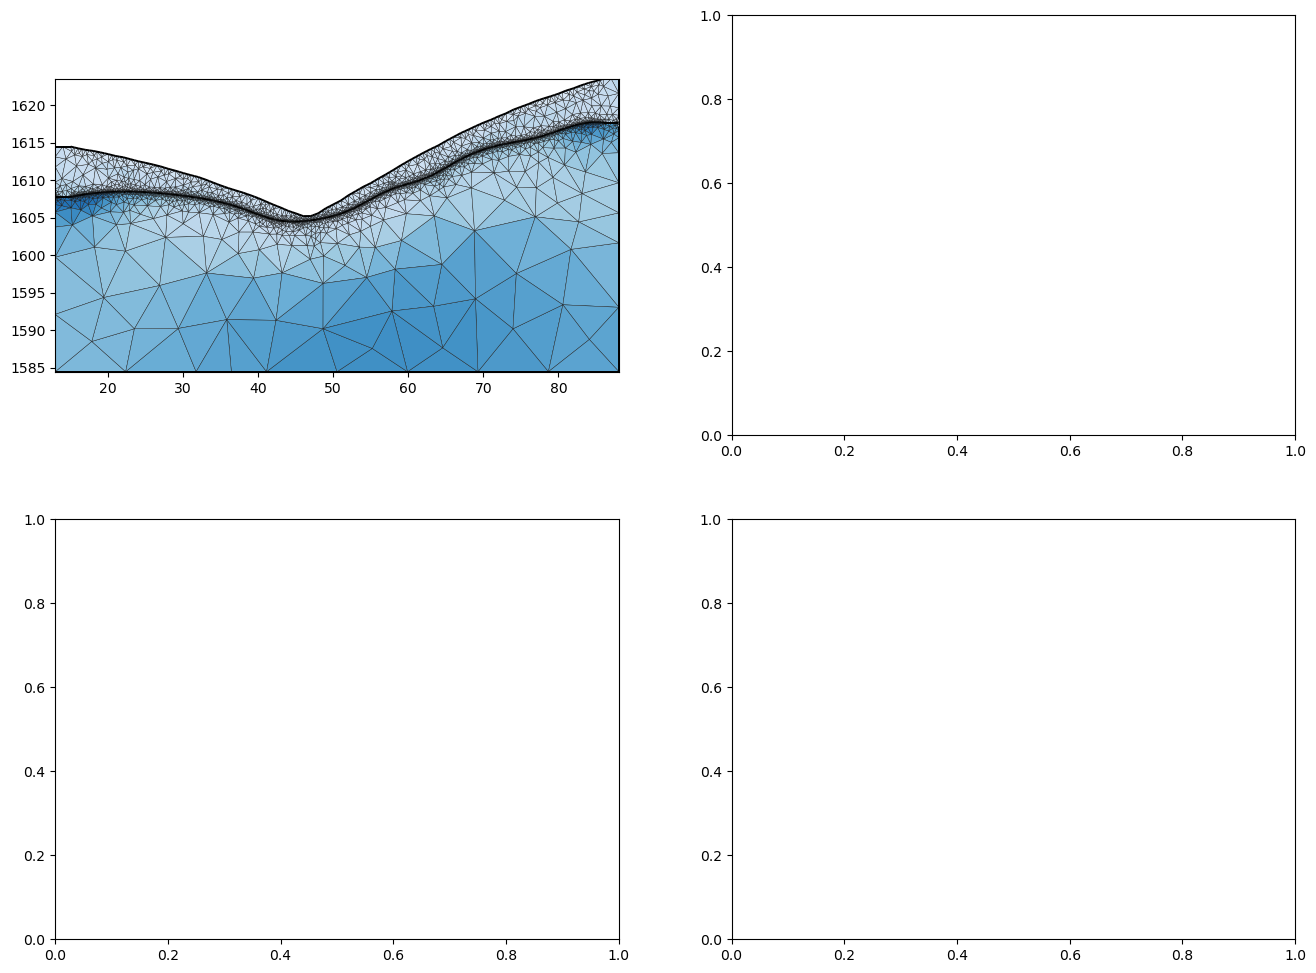

AttributeError: 'tuple' object has no attribute 'cmap'

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pygimli as pg
import sys
from tqdm import tqdm  # For progress bars

# For Jupyter notebooks, use the current working directory
try:
    # For regular Python scripts
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # For Jupyter notebooks
    current_dir = os.getcwd()
# Add the parent directory (OPEN_ERT) to the path
parent_dir = os.path.dirname(os.path.dirname(current_dir))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Import the resistivity_to_saturation function from your module
from watershed_geophysics.petrophysics.resistivity_models import resistivity_to_saturation

# Extract the inverted resistivity values
resistivity_values = np.load("results/Structure_WC/resmodel.npy")
coverage = np.load("results/Structure_WC/all_coverage.npy")
# Extract cell markers from the mesh (to identify different geological layers)
cell_markers = np.load("results/Structure_WC/index_marker.npy")

mesh = pg.load("results/Structure_WC/mesh_res.bms")

# Number of Monte Carlo realizations
n_realizations = 100

# Set up parameter distributions (means and standard deviations)
# Layer 1 (top layer - marker 3)
layer1_dist = {
    'rhos': {'mean': 100.0, 'std': 20.0},       # Saturated resistivity (ohm-m)
    'n': {'mean': 2.2, 'std': 0.2},             # Saturation exponent
    'sigma_sur': {'mean': 1/500, 'std': 1/2000},  # Surface conductivity (S/m)
    'porosity': {'mean': 0.40, 'std': 0.05}      # Porosity
}

# Layer 2 (bottom layer - marker 2)
layer2_dist = {
    'rhos': {'mean': 500.0, 'std': 100.0},      # Saturated resistivity (ohm-m)
    'n': {'mean': 1.8, 'std': 0.2},             # Saturation exponent
    'sigma_sur': {'mean': 0, 'std': 1/5000},    # Surface conductivity (S/m)
    'porosity': {'mean': 0.35, 'std': 0.05}      # Porosity
}

# Create arrays to store all MC realization results
water_content_all = np.zeros((n_realizations, *resistivity_values.shape))

# Create arrays to store the parameters used for each realization
params_used = {
    'layer1': {
        'rhos': np.zeros(n_realizations),
        'n': np.zeros(n_realizations),
        'sigma_sur': np.zeros(n_realizations),
        'porosity': np.zeros(n_realizations)
    },
    'layer2': {
        'rhos': np.zeros(n_realizations),
        'n': np.zeros(n_realizations),
        'sigma_sur': np.zeros(n_realizations),
        'porosity': np.zeros(n_realizations)
    }
}

# Perform Monte Carlo simulation
for mc_idx in tqdm(range(n_realizations), desc="Monte Carlo Simulations"):
    # Sample parameters for each layer from their distributions
    # Layer 1
    layer1_params = {
        'rhos': max(1.0, np.random.normal(layer1_dist['rhos']['mean'], layer1_dist['rhos']['std'])),
        'n': max(1.0, np.random.normal(layer1_dist['n']['mean'], layer1_dist['n']['std'])),
        'sigma_sur': max(0.0, np.random.normal(layer1_dist['sigma_sur']['mean'], layer1_dist['sigma_sur']['std']))
    }
    
    # Layer 2
    layer2_params = {
        'rhos': max(1.0, np.random.normal(layer2_dist['rhos']['mean'], layer2_dist['rhos']['std'])),
        'n': max(1.0, np.random.normal(layer2_dist['n']['mean'], layer2_dist['n']['std'])),
        'sigma_sur': max(0.0, np.random.normal(layer2_dist['sigma_sur']['mean'], layer2_dist['sigma_sur']['std']))
    }
    
    # Sample porosity for each layer
    porosity = np.zeros_like(cell_markers, dtype=float)
    layer1_porosity = np.clip(np.random.normal(layer1_dist['porosity']['mean'], 
                                              layer1_dist['porosity']['std']), 0.05, 0.6)
    layer2_porosity = np.clip(np.random.normal(layer2_dist['porosity']['mean'], 
                                              layer2_dist['porosity']['std']), 0.05, 0.6)
    
    porosity[cell_markers == 3] = layer1_porosity  # Top layer porosity
    porosity[cell_markers == 2] = layer2_porosity  # Bottom layer porosity
    
    # Save the parameters used for this realization
    params_used['layer1']['rhos'][mc_idx] = layer1_params['rhos']
    params_used['layer1']['n'][mc_idx] = layer1_params['n']
    params_used['layer1']['sigma_sur'][mc_idx] = layer1_params['sigma_sur']
    params_used['layer1']['porosity'][mc_idx] = layer1_porosity
    
    params_used['layer2']['rhos'][mc_idx] = layer2_params['rhos']
    params_used['layer2']['n'][mc_idx] = layer2_params['n']
    params_used['layer2']['sigma_sur'][mc_idx] = layer2_params['sigma_sur']
    params_used['layer2']['porosity'][mc_idx] = layer2_porosity
    
    # Create arrays to store water content and saturation for this realization
    water_content = np.zeros_like(resistivity_values)
    saturation = np.zeros_like(resistivity_values)
    
    # Process each timestep
    for t in range(resistivity_values.shape[1]):
        # Extract resistivity for this timestep
        resistivity_t = resistivity_values[:, t]
        
        # Process each layer separately
        # Layer 1 (marker 3)
        mask_layer1 = cell_markers == 3
        if np.any(mask_layer1):
            saturation[mask_layer1, t] = resistivity_to_saturation(
                resistivity_t[mask_layer1],
                layer1_params['rhos'],
                layer1_params['n'],
                layer1_params['sigma_sur']
            )
        
        # Layer 2 (marker 2)
        mask_layer2 = cell_markers == 2
        if np.any(mask_layer2):
            saturation[mask_layer2, t] = resistivity_to_saturation(
                resistivity_t[mask_layer2],
                layer2_params['rhos'],
                layer2_params['n'],
                layer2_params['sigma_sur']
            )
        
        # Convert saturation to water content (water_content = saturation * porosity)
        water_content[:, t] = saturation[:, t] * porosity
    
    # Store this realization's water content
    water_content_all[mc_idx] = water_content

# Calculate statistics across all realizations
water_content_mean = np.mean(water_content_all, axis=0)
water_content_std = np.std(water_content_all, axis=0)
water_content_p10 = np.percentile(water_content_all, 10, axis=0)  # 10th percentile
water_content_p50 = np.percentile(water_content_all, 50, axis=0)  # Median
water_content_p90 = np.percentile(water_content_all, 90, axis=0)  # 90th percentile

# Visualize mean water content for a specific timestep
timestep_to_plot = 0  # Change to visualize different timesteps

# Plot mean, standard deviation, and percentiles
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Mean water content
im1 = pg.show(mesh, water_content_mean[:, timestep_to_plot], 
        ax=axs[0, 0], cmap="Blues", cMin=0, cMax=0.45,
        showMesh=True, label="Mean Water Content (-)")
axs[0, 0].set_title(f"Mean Water Content - Timestep {timestep_to_plot+1}")
fig.colorbar(im1, ax=axs[0, 0])

# Standard deviation
im2 = pg.show(mesh, water_content_std[:, timestep_to_plot], 
        ax=axs[0, 1], cmap="Reds", cMin=0, cMax=0.1,
        showMesh=True, label="Std. Dev. Water Content (-)")
axs[0, 1].set_title(f"Standard Deviation - Timestep {timestep_to_plot+1}")
fig.colorbar(im2, ax=axs[0, 1])

# 10th percentile
im3 = pg.show(mesh, water_content_p10[:, timestep_to_plot], 
        ax=axs[1, 0], cmap="Blues", cMin=0, cMax=0.45,
        showMesh=True, label="P10 Water Content (-)")
axs[1, 0].set_title(f"10th Percentile - Timestep {timestep_to_plot+1}")
fig.colorbar(im3, ax=axs[1, 0])

# 90th percentile
im4 = pg.show(mesh, water_content_p90[:, timestep_to_plot], 
        ax=axs[1, 1], cmap="Blues", cMin=0, cMax=0.45,
        showMesh=True, label="P90 Water Content (-)")
axs[1, 1].set_title(f"90th Percentile - Timestep {timestep_to_plot+1}")
fig.colorbar(im4, ax=axs[1, 1])

plt.tight_layout()
plt.show()

# Plot coefficient of variation (uncertainty measure)
plt.figure(figsize=(10, 6))
coef_var = water_content_std[:, timestep_to_plot] / (water_content_mean[:, timestep_to_plot] + 1e-6)
coef_var = np.clip(coef_var, 0, 1)  # Clip to reasonable range
im = pg.show(mesh, coef_var, 
        cmap="hot_r", cMin=0, cMax=0.5,
        showMesh=True, label="Coefficient of Variation (-)")
plt.title(f"Uncertainty (CV) - Timestep {timestep_to_plot+1}")
plt.colorbar(im)
plt.tight_layout()
plt.show()

# Plot distributions of parameters used
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

# Layer 1 parameters
axs[0, 0].hist(params_used['layer1']['rhos'], bins=20)
axs[0, 0].set_title('Layer 1 - Rhos')
axs[0, 0].set_xlabel('Rhos (ohm-m)')

axs[0, 1].hist(params_used['layer1']['n'], bins=20)
axs[0, 1].set_title('Layer 1 - n')
axs[0, 1].set_xlabel('n')

axs[0, 2].hist(params_used['layer1']['sigma_sur'], bins=20)
axs[0, 2].set_title('Layer 1 - sigma_sur')
axs[0, 2].set_xlabel('sigma_sur (S/m)')

axs[0, 3].hist(params_used['layer1']['porosity'], bins=20)
axs[0, 3].set_title('Layer 1 - porosity')
axs[0, 3].set_xlabel('porosity')

# Layer 2 parameters
axs[1, 0].hist(params_used['layer2']['rhos'], bins=20)
axs[1, 0].set_title('Layer 2 - Rhos')
axs[1, 0].set_xlabel('Rhos (ohm-m)')

axs[1, 1].hist(params_used['layer2']['n'], bins=20)
axs[1, 1].set_title('Layer 2 - n')
axs[1, 1].set_xlabel('n')

axs[1, 2].hist(params_used['layer2']['sigma_sur'], bins=20)
axs[1, 2].set_title('Layer 2 - sigma_sur')
axs[1, 2].set_xlabel('sigma_sur (S/m)')

axs[1, 3].hist(params_used['layer2']['porosity'], bins=20)
axs[1, 3].set_title('Layer 2 - porosity')
axs[1, 3].set_xlabel('porosity')

plt.tight_layout()
plt.show()



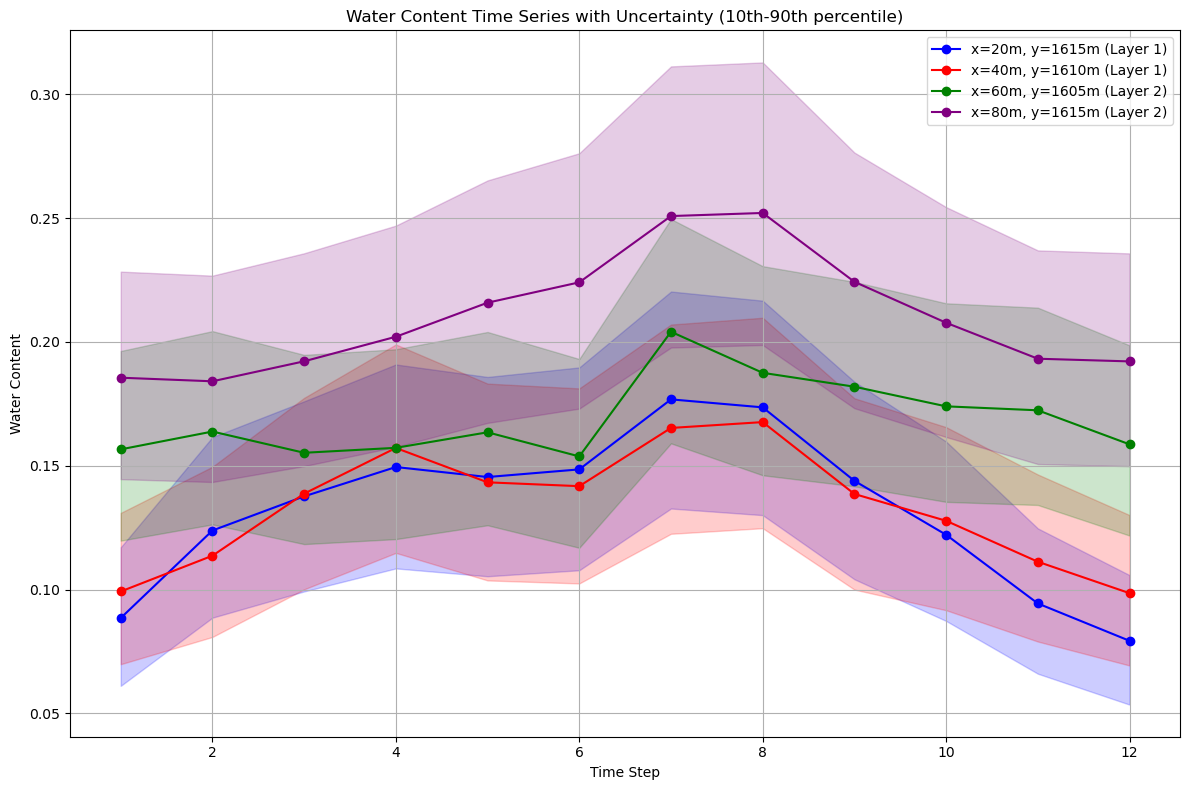

16/05/25 - 11:50:41 - pyGIMLi - WARNING - Keyword argument changed from 'cmap' to 'cMap' and will be removed in v 


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

<Figure size 1200x600 with 0 Axes>

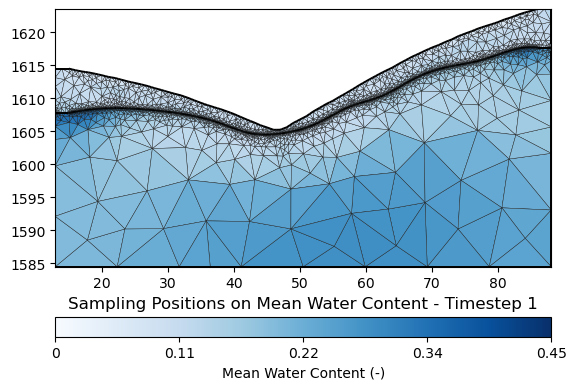

In [2]:
# Modified function to extract time series based on x AND y positions
def extract_mc_time_series(mesh, values_all, positions):
    """
    Extract Monte Carlo time series at specific x,y positions
    
    Args:
        mesh: PyGIMLI mesh
        values_all: Array of all Monte Carlo realizations (n_realizations, n_cells, n_timesteps)
        positions: List of (x,y) coordinate tuples
        
    Returns:
        time_series: Array of shape (n_positions, n_realizations, n_timesteps)
        cell_indices: List of cell indices corresponding to the positions
    """
    n_realizations = values_all.shape[0]
    n_timesteps = values_all.shape[2]
    
    # Find indices of cells closest to specified positions
    cell_indices = []
    for x_pos, y_pos in positions:
        # Calculate distance from each cell center to the position
        cell_centers = np.array(mesh.cellCenters())
        distances = np.sqrt((cell_centers[:, 0] - x_pos)**2 + (cell_centers[:, 1] - y_pos)**2)
        cell_idx = np.argmin(distances)
        cell_indices.append(cell_idx)
    
    # Extract time series for each realization and position
    time_series = np.zeros((len(positions), n_realizations, n_timesteps))
    
    for pos_idx, cell_idx in enumerate(cell_indices):
        for mc_idx in range(n_realizations):
            time_series[pos_idx, mc_idx, :] = values_all[mc_idx, cell_idx, :]
    
    return time_series, cell_indices

# Define positions to sample (x,y coordinates)
positions = [
    (20, 1615),  # Example coordinates, adjust based on your model
    (40, 1610),
    (60, 1605),
    (80, 1615)
]

# Extract time series data for these positions
time_series_data, cell_indices = extract_mc_time_series(mesh, water_content_all, positions)

# Plot time series with uncertainty bands
plt.figure(figsize=(12, 8))
colors = ['blue', 'red', 'green', 'purple']
measurement_times = range(1, resistivity_values.shape[1] + 1)  # Assuming sequential timesteps

for pos_idx, (x_pos, y_pos) in enumerate(positions):
    # Get cell marker for this position to know which layer it's in
    cell_idx = cell_indices[pos_idx]
    layer = "Layer 1" if cell_markers[cell_idx] == 3 else "Layer 2"
    
    # Calculate statistics
    mean_ts = np.mean(time_series_data[pos_idx], axis=0)
    p10_ts = np.percentile(time_series_data[pos_idx], 10, axis=0)
    p90_ts = np.percentile(time_series_data[pos_idx], 90, axis=0)
    
    # Plot mean and uncertainty band
    plt.plot(measurement_times, mean_ts, 'o-', color=colors[pos_idx], 
             label=f'x={x_pos}m, y={y_pos}m ({layer})')
    plt.fill_between(measurement_times, p10_ts, p90_ts, color=colors[pos_idx], alpha=0.2)

plt.xlabel('Time Step')
plt.ylabel('Water Content')
plt.title('Water Content Time Series with Uncertainty (10th-90th percentile)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot specific locations on the mesh alongside with the water content data
plt.figure(figsize=(12, 6))
im = pg.show(mesh, water_content_mean[:, timestep_to_plot], 
        cmap="Blues", cMin=0, cMax=0.45,
        showMesh=True, label="Mean Water Content (-)")

# Add markers for the sampled positions
for i, (x_pos, y_pos) in enumerate(positions):
    plt.plot(x_pos, y_pos, 'o', color=colors[i], markersize=10, 
             label=f'Position {i+1}: ({x_pos}, {y_pos})')

plt.title(f"Sampling Positions on Mean Water Content - Timestep {timestep_to_plot+1}")
plt.colorbar(im)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
np.max((resistivity_t[mask_layer2]/500.0) ** (-1.8))

2.949229835665885

In [ ]:
np.max(saturation[mask_layer2, :])

1.0

In [ ]:
np.max(saturation[mask_layer1, :])

0.6226561450043193

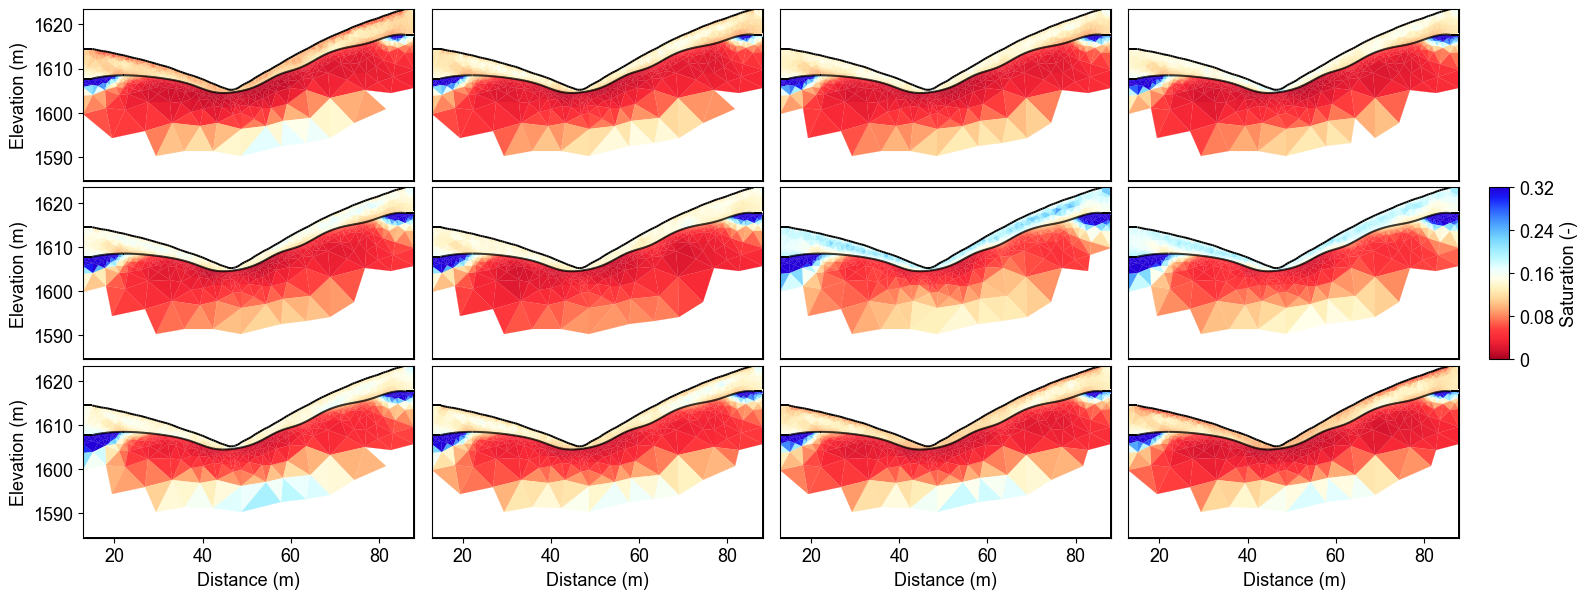

In [ ]:
from palettable.lightbartlein.diverging import BlueDarkRed18_18_r
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pylab as pylab
params = {'legend.fontsize': 13,
          #'figure.figsize': (15, 5),
         'axes.labelsize': 13,
         'axes.titlesize':13,
         'xtick.labelsize':13,
         'ytick.labelsize':13}

pylab.rcParams.update(params)
plt.rcParams["font.family"] = "Arial"

fixed_cmap = BlueDarkRed18_18_r.mpl_colormap
fig = plt.figure(figsize=[16, 6])

# Use tight_layout with adjusted parameters to reduce space
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# True resistivity model
for i in range(12):
    row, col = i // 4, i % 4
    ax = fig.add_subplot(3, 4, i+1)
    
    # Add common ylabel only to leftmost panels
    ylabel = "Elevation (m)" if col == 0 else None
    
    # Add resistivity label only to the middle-right panel (row 1, col 3)
    resistivity_label = ' Resistivity ($\Omega$ m)' if (i == 7) else None
    
    # Only show axis ticks on leftmost and bottom panels
    if col != 0:
        ax.set_yticks([])
    
    if row != 2:  # Not bottom row
        ax.set_xticks([])
    else:
        # Add "distance (m)" label to bottom row panels
        ax.set_xlabel("Distance (m)")
    
    # Create the plot
    ax, cbar = pg.show(mesh,
                      water_content[:, i],
                      pad=0.3,
                      orientation="vertical",
                      cMap=fixed_cmap,
                      cMin=0,
                      cMax=0.32,
                      ylabel=ylabel,
                      label= 'Saturation (-)',
                      ax=ax,
                      logScale=False,
                      coverage=coverage[i,:]>-1.2)
    
    # Only keep colorbar for the middle-right panel (row 1, col 3)
    # This corresponds to panel index 7 in a 0-based indexing system
    if i != 7:  # Keep only the colorbar for panel 7
        cbar.remove()

plt.tight_layout()
plt.savefig("results/Structure_WC/timelapse_sat.tiff", dpi=300, bbox_inches='tight')

In [ ]:

# Create a time-series plot to show water content changes over time
def extract_time_series(mesh, values, x_positions):
    """Extract time series at specific x positions"""
    time_series = []
    for x_pos in x_positions:
        # Find closest cell to this position
        cell_idx = np.argmin(np.abs(mesh.cellCenters()[:, 0] - x_pos))
        time_series.append(values[cell_idx, :])
    return time_series

# Define positions to sample (adjust based on your model dimensions)
x_positions = [20, 40, 60, 80]
time_series = extract_time_series(mesh_with_interface, water_content, x_positions)

# Plot time series
plt.figure(figsize=(10, 6))
for i, x_pos in enumerate(x_positions):
    plt.plot(measurement_times, time_series[i], 'o-', label=f'x={x_pos}m')
plt.xlabel('Time (days)')
plt.ylabel('Water Content')
plt.title('Water Content Time Series at Selected Locations')
plt.legend()
plt.grid(True)
plt.tight_layout()


NameError: name 'mesh_with_interface' is not defined